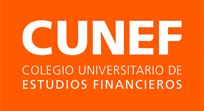

# Máster en Data Science - Machine Learning

# Predicción de fraude mediante el uso de modelos de Machine Learning
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
## DataSet: Bank Account Fraud Dataset Suite (NeurIPS 2022)

# <font size=25><b>Implementación del modelo elegido: <font color='gold'>Light</font><font color='deepskyblue'>GBM</font></b></font>

Una vez seleccionados los hiperparámetros procedo a implementar el modelo elegido y predecir los valores del dataset de test para con estas predicciones obtener las métricas clave del modelo.

In [250]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import StandardScaler
import importlib
import warnings
import sys

import scikitplot as skplt
from sklearn import metrics
from sklearn.pipeline import Pipeline
import lightgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder

from sklearn.metrics import balanced_accuracy_score, fbeta_score, make_scorer,\
                            accuracy_score,average_precision_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Funciones

In [248]:
sys.path.append('../src/')
import functions_rfc as fr
sys.path.remove('../src/')

### Constantes:
seed=10

In [251]:
sys.path.append('../src/')
importlib.reload(fr)
sys.path.remove('../src/')

***
## Importo datasets

En esta ocación no voy a importar el dataset con undersampling por más que ya lo tenga procesado, debido a que se trata de un nuevo problema y sobre todo en cuanto al test, intentaré tratar esta parte como si tuviese listo el sistema de preprocesamiento y del modelo como para introducirlo luego en producción.

Por ello volveré a utilizar mis funciones de preprocesamiento que contienen los pipelines para procesar nuevamente train y test a continuación:

In [254]:
#df_train_under = pd.read_csv('../data/processed/df_train_undersamp_ready.csv')
df_fraud_train = pd.read_csv('../data/interim/df_fraud_train.csv')
df_fraud_test = pd.read_csv('../data/interim/df_fraud_test.csv')

In [255]:
preprocessor = fr.preprocessing(df_fraud_train) # genero mi objeto de preprocessing instanciando internamente un pipeline
preprocessor.fit(df_fraud_train, df_fraud_train.fraud_bool) # entreno con el dataset de train
df_train = fr.feature_selection(preprocessor.transform(df_fraud_train)) # aplico transformación y feature selection al train
df_test = fr.feature_selection(preprocessor.transform(df_fraud_test)) # aplico transformación y feature selection al test

In [262]:
X_train = df_train.drop('fraud_bool', axis=1)
y_train = df_train['fraud_bool']

X_test = df_test.drop('fraud_bool', axis=1)
y_test = df_test['fraud_bool']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700000, 29), (700000,), (300000, 29), (300000,))

In [263]:
undersamp = RandomUnderSampler(sampling_strategy=0.08, random_state=seed) # aplico undersampling al set de entrenamiento
X_train_under, y_train_under = undersamp.fit_resample(X_train, y_train)

X_train_under.shape, y_train_under.shape

((104220, 29), (104220,))

Y ahora si, el preprocesamiento se ha realizado de manera automática perfectamente.

Esto mismo también podría realizarse mediante el uso de un pipeline en conjunto con el modelo, pero yo prefiero separar las cosas. Por un lado debido a que
me gusta dejar prolijo paso a paso el proceso, que además he automatizado con las funciones, cuyo pipeline ya está contenido internamente. Además, justo el LGBM es un modelo rápido y he realizado un undersampling en mis datos, pero de no ser así también demoraría más el proceso.

Aún así dejo aquí el ejemplo:
```Python
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMClassifier(...))])
```

Ahora si procedo a ejecutar y medir mi modelo sobre los datasets ya procesados.

# Entrenamiento del modelo

Entrenamos el modelo con los hiperparámetros seleccionados mediante el RandomSearchCV

In [264]:
cv = load('../models/CV2_lgbm.joblib') # de entre los CV que probé, parece ser el más específico y el que dio mejores métricas en el CV

In [265]:
cv.best_params_

{'subsample': 0.9929166342896103,
 'num_leaves': 426,
 'n_estimators ': 452,
 'min_data_in_leaf': 1085,
 'min_child_samples': 67,
 'max_depth': 8,
 'learning_rate': 0.04629313327552674,
 'colsample_bytree': 0.9028009600012047}

In [276]:
%%time
lgbm = LGBMClassifier(num_leaves=426
                      ,n_estimators=452
                      ,min_data_in_leaf=1085
                      ,max_depth=5 # disminuyo este valor para alivianar un poco y porque me pareció que podía dar mejor resultado, y así fue
                      ,learning_rate=0.047
                      ,subsample=0.99
                      ,min_child_samples=67
                      ,colsample_bytree=0.9
                      ,verbosity=-1)

lgbm.fit(X_train_under, y_train_under)

y_pred = lgbm.predict(X_test)

fr.metrics_summ(y_test, y_pred)


Accuracy: 0.98048
Balanced Accuracy: 0.64333
F2 score: 0.27815
F1 score: 0.25227
Precision: 0.21839
Recall: 0.29858

Confusion Matrix:
[[293155   3536]
 [  2321    988]]
CPU times: total: 31 s
Wall time: 14.1 s


Tanto el F1 como el F2 han mejorado relativamente, gracias a la búsqueda de hiperparámetros. He realizado dos búsquedas con CV y el mejor luego de las modificaciones es el cv2.

In [277]:
y_pred_proba = lgbm.predict_proba(X_test)
y_pred_proba

array([[0.9853291 , 0.0146709 ],
       [0.99814812, 0.00185188],
       [0.77420836, 0.22579164],
       ...,
       [0.99411624, 0.00588376],
       [0.99873454, 0.00126546],
       [0.99001646, 0.00998354]])

In [278]:
proba_tags = pd.concat([pd.Series(y_pred_proba[:,1]),pd.Series(y_pred)],axis=1).rename(columns={0:'Probability', 1:'Default'})
proba_tags[proba_tags.Default == 1].Probability.describe()

count    4524.000000
mean        0.647403
std         0.112197
min         0.500014
25%         0.554583
50%         0.621416
75%         0.721887
max         0.980505
Name: Probability, dtype: float64

Una vez definido el modelo y con unas métricas aceptables, que mejoraron gracias al hyperparameter tunning, procedo con tareas importantes como lo son
generar los gráficos que midan al modelo, buscar el threshold que mejor satisfaga los objetivos del proyecto y por supuesto, una vez terminado esto, obtener las mediciones finales de la aplicación del LightGBM.

***
# ROC Curve

Utilizo una función propia basada en conceptos de la cátedra para poder graficar la curva ROC:

Best Threshold = 0.068645, G-Mean = 0.819

*************************************************************

El coeficiente de GINI es: 0.80

El área por debajo de la curva ROC es: 0.8978

*************************************************************


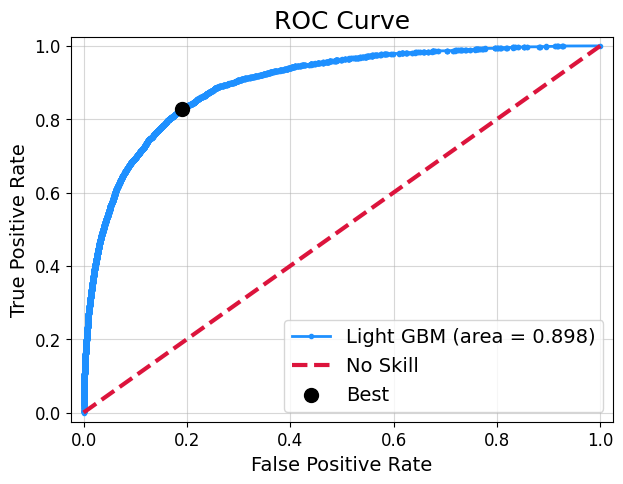

In [279]:
fr.roc_curve_plot(y_test, y_pred_proba[:,1], model_name='Light GBM', figsize=(7,5))
plt.show()

Podemos ver claramente con el área bajo la curva es bastante grande, pero no podemos dejar de comentar que, al tratarse de un dataset desbalanceado
esta métrica pasa a perder cierta importancia relativa, debido a que claramente vamos a tener muchos verdaderos positivos en base a la clase 0, pero es algo que no suma a nuestro objetivo eso (luego esto se puede ver ejemplificado en la matriz de coste), debido a que lo que nos importa a nosotros son los falsos positivos y negativos de la clase 1, es decir, de los fraudes.

El punto negro indica el mejor threshold, en donde en principio se lograría la mayor cantidad de verdaderos positivos en conjunto con la menor cantidad de falsos positivos, aunque no tiene porque ser este el objetivo de negocio que tenemos. Es decir, clasificar a muchísima gente como fraude podría generar que incurramos en costos muy altos de investigación. Aunque nuevamente, estas decisiones dependerán de cuestiones detalladas de negocio y eficiencia económica. El modelo es así y uno luego puede decidir donde poner el umbral de decisión analizando muchos aspectos. En un apartado más adelante se mostrarán las matrices de confusión y métricas para cas Threshold

# Precision - Recall Curve

Por otro lado, procedo a realizar un gráfico muy interesante, sobre todo en relación al este trabajo: La curva de Precision-Recall, en donde se puede
observar la relación visual entre ambas métricas. Es normal ver que la relación entre el crecimiento de Precision y Recall es negativa, lo cual nos hace vernos obligados a sacrificar parte de uno si queremos mejorar el otro.

En este caso el punto negro indica el punto óptimo para maximizar la métrica F2 Score, una de las importantes que seteamos para nuestro modelo. Si buscamos un punto que optimize el F2 será en un Recall cercano al 50%, pero sacrificando precisión hasta cerca del 15%. En este caso veremos que el threshold es mucho más alto, del 0,32, por lo que se tendrá más precisión y se logrará maximizar el F2, algo bastante equilibrado entre precision y recall por más que este último tenga más importancia relativa. De igual manera, he de tener en cuenta que esto haría disminuír la cantidad de fraudes detectados con respecto al otro threshold, pero será más razonable desde el punto de vista del ratio entre la cantidad de investigaciones a realizar y de fraudes correctos detectados.

Best Threshold = 0.32159, F2 Score = 0.320, AUC = 0.1794


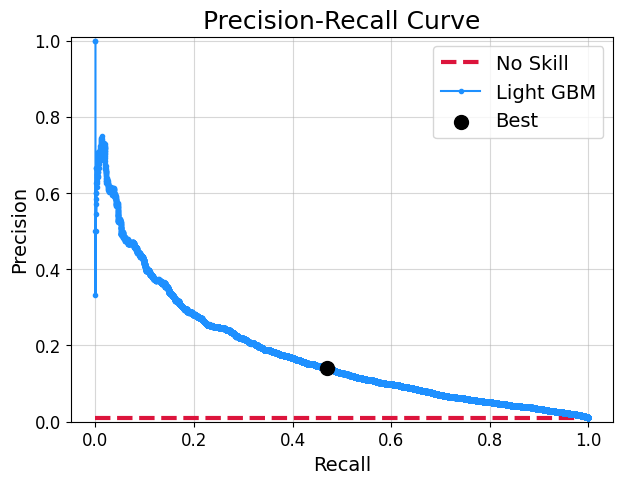

In [317]:
#precision_recall_curve_plot(y_train, y_pred_proba_train[:,1], ax=ax1, title='TRAIN', f_score_beta=2, model_name='Light GBM') # No son comparables!
fr.pr_curve_plot(y_test, y_pred_proba[:,1], f_score_beta=2, model_name='Light GBM', figsize=(7,5))

# Cumulative Gain Curve

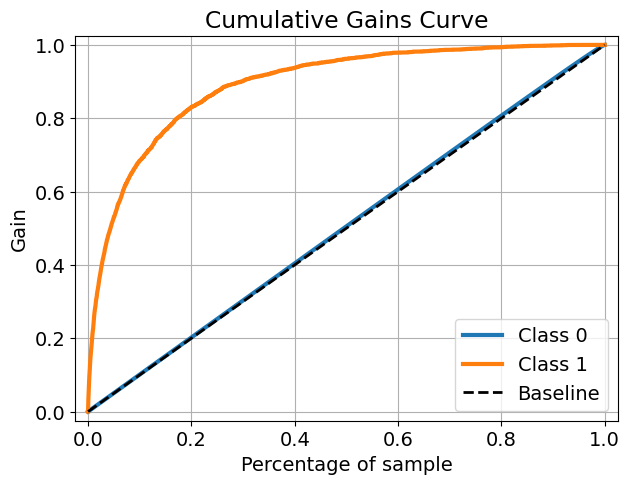

In [309]:
fig, ax = plt.subplots(figsize=(7,5))
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba, ax=ax)
ax.set_xlim([-0.025, 1.025])
ax.set_ylim([-0.025, 1.025])
plt.show()

En este gráfico de gran importancia en nuestros análisis, podemos observar como, si ordenamos las probabilidades de mayor a menor, podemos de alguna
manera medir la potencia de nuestro modelo. Es decir, en este caso con menos del 40% de los datos se podría predecir el 90% del fraude registrado.

Esto nos permite conocer, por ejemplo, a cuantos potenciales fraudes investigar si logro obtener las probabilidades de cada individuo y ordenarlas de mayor a menor, para lograr detectar a una cantidad considerable sin tener que analizar todo el conjunto de individuos.

Si la ordenación no sirviese, es decir, la probabilidad no me agregara mucho valor, la curva se encontraría mucho más cerca de la recta diagonal que sería el no tener un modelo, o aplicar el modelo base. Podemos ver que la Clase 0 (no fraude) se ubica prácticamente en esa línea, lo cual es normal en set de datos tan desbalanceados como éste, coincidiendo también con el hecho de que el modelo base detectaría bien los 0 (en realidad simplemente setearía a todas las instancias como 0) pero sin agregar más valor.

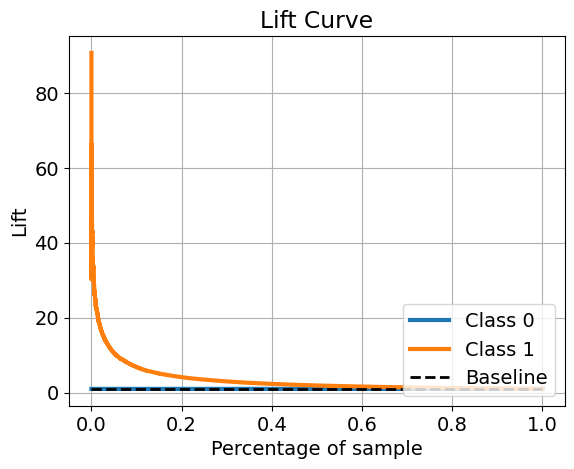

In [310]:
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()
## Muestro como haría la lift curve también, pero al tratarse del mismo concepto no me voy a repetir en lo ya comentado

## Búsqueda del Threshold ideal

A continuación generaré un gráfico basado en una idea presentada por la cátedra en donde se puede observar el cambio en las métricas de Precision y Recall a medida que cambia el valor del threshold. A su vez, yo agregué tanto el F1 como el F2 debido a que son las métricas a las que más importancia les estoy dando.

Aún así, elijo privilegiar el F2, respetando el objetivo que se determinó en el Business Case y por ende también busco marcar el threshold óptimo para maximizar esta métrica, sacrificando seguramente Precision a cambio de aumentar el Recall.

Este gráfico tiene la gran ventaja de lograr representar gráficamente parte de lo que buscábamos: las combinaciones de las principales métricas analizadas por cada threshold que elijamos.

In [311]:
%%time
prob_predictions = y_pred_proba[:,1]
recall_precision = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions]
    recall_precision.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

CPU times: total: 2min
Wall time: 2min 58s


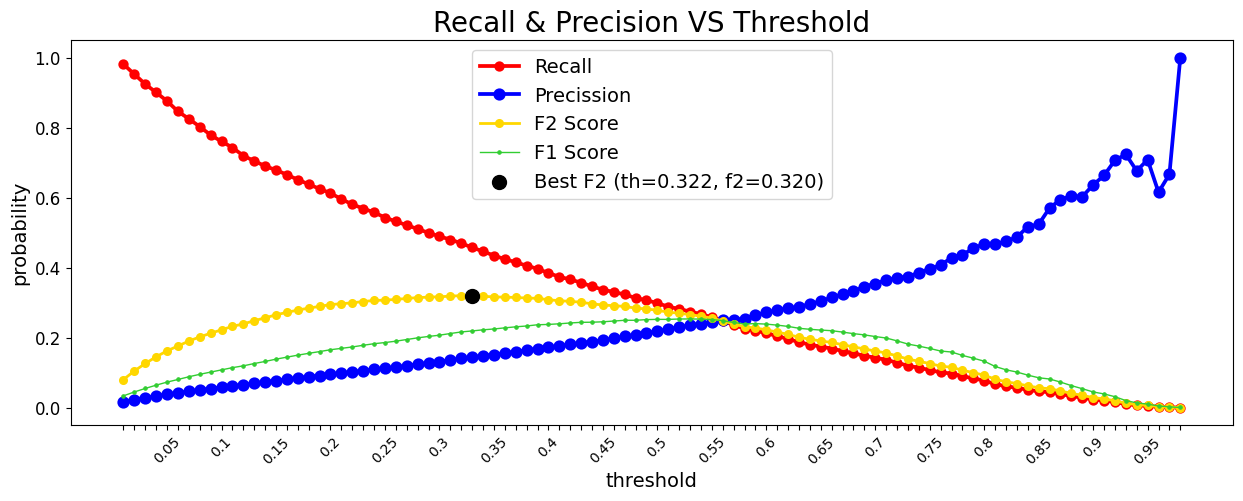

In [312]:
fr.plot_recall_precission(recall_precision, y_test, y_pred_proba[:,1])

Podemos ver que el mejor threshold para el F2 se aleja de la intersección de las series. El F1 se acercaría más, pero el equilibrio perfecto entre
ambas métricas no es necesariamente lo que mejor se condice con los objetivos del negocio, esto puede variar por supuesto. Es más, me atrevería a decir que no descartaría usar métricas que premien aún más al recall como un F3 o F4, pero al no ser tan convencionales no me meteré ahí, sino que simplemente analizaré preponderar más o menos al recall.

Cada quien podrá tener sus opiniones, pero para el caso de negocio planteado yo decido priorizar el F2 sobre el F1 y por ende en cierta medida el Recall sobre la Precision, entendiendo que será mejor incurrir en una mayor cantidad de falsos positivos con el fin de capturar una cantidad mayor de fraudes. Esto por supuesto indicaría un costo de investigación de posibles fraudes mayor, por lo que una matriz de costos sería ideal para medir hasta donde se puede ir en este sentido de englobar la mayor cantidad posible de potenciales fraudes.

# Confusion Matrix

Una vez graficadas las principales curvas para medir al modelo procedo a actualizar la matriz de confusión que he mostrado en su versión por defecto con anterioridad, en este caso utilizando el threshold que maximize el F2, observando como cambian las demás métricas al aplicar dicha medida.

In [306]:
y_pred_th_f2 = np.where(proba_tags.Probability>0.32159,1,0) # Threshold que maximiza el F2
y_pred_th_roc = np.where(proba_tags.Probability>0.068645,1,0) # Threshold óptimo de la curva ROC (mejor proporción promedio TP y FP). Alto Recall pero muchos FP.
y_pred_th_5fp = np.where(proba_tags.Probability>0.2424,1,0) # Threshold ejemplo de caso de negocio en donde se aceptan max 5% de FP
proba_tags['Threshold F2'] = y_pred_th_f2
proba_tags['Threshold Roc'] = y_pred_th_roc
proba_tags['Threshold 5% FP'] = y_pred_th_5fp
proba_tags

,Probability,Default,Threshold F2,Threshold Roc,Threshold 5% FP
0,0.014671,0,0,0,0
1,0.001852,0,0,0,0
2,0.225792,0,0,1,0
3,0.066559,0,0,0,0
4,0.095232,0,0,1,0
...,...,...,...,...,...
299995,0.001933,0,0,0,0
299996,0.021341,0,0,0,0
299997,0.005884,0,0,0,0
299998,0.001265,0,0,0,0


In [313]:
print("\033[1mMáximizando el F2 --> Threshold 0.32:\033[0m")
fr.metrics_summ(y_test, y_pred_th_f2)
print('__________________________________________\n')

print("\033[1mMejor proporción promedio TP y FP, óptimo curva ROC. Alto Recall pero muchos FP --> Threshold 0.07\033[0m")
fr.metrics_summ(y_test, y_pred_th_roc)
print('__________________________________________\n')

print("\033[1mEjemplo de caso de negocio en donde se aceptan max 5% de FP --> Threshold 0.24:\033[0m")
fr.metrics_summ(y_test, y_pred_th_5fp)

Máximizando el F2 --> Threshold 0.32:

Accuracy: 0.96268
Balanced Accuracy: 0.71846
F2 score: 0.32012
F1 score: 0.21695
Precision: 0.14114
Recall: 0.46872

Confusion Matrix:
[[287253   9438]
 [  1758   1551]]
__________________________________________

Mejor proporción promedio TP y FP, óptimo curva ROC. Alto Recall pero muchos FP --> Threshold 0.07

Accuracy: 0.80917
Balanced Accuracy: 0.81880
F2 score: 0.18869
F1 score: 0.08742
Precision: 0.04614
Recall: 0.82865

Confusion Matrix:
[[240009  56682]
 [   567   2742]]
__________________________________________

Ejemplo de caso de negocio en donde se aceptan max 5% de FP --> Threshold 0.24:

Accuracy: 0.94559
Balanced Accuracy: 0.75120
F2 score: 0.30562
F1 score: 0.18299
Precision: 0.10966
Recall: 0.55243

Confusion Matrix:
[[281849  14842]
 [  1481   1828]]


### 1. Matriz de confusión por default (threshold 0.5):

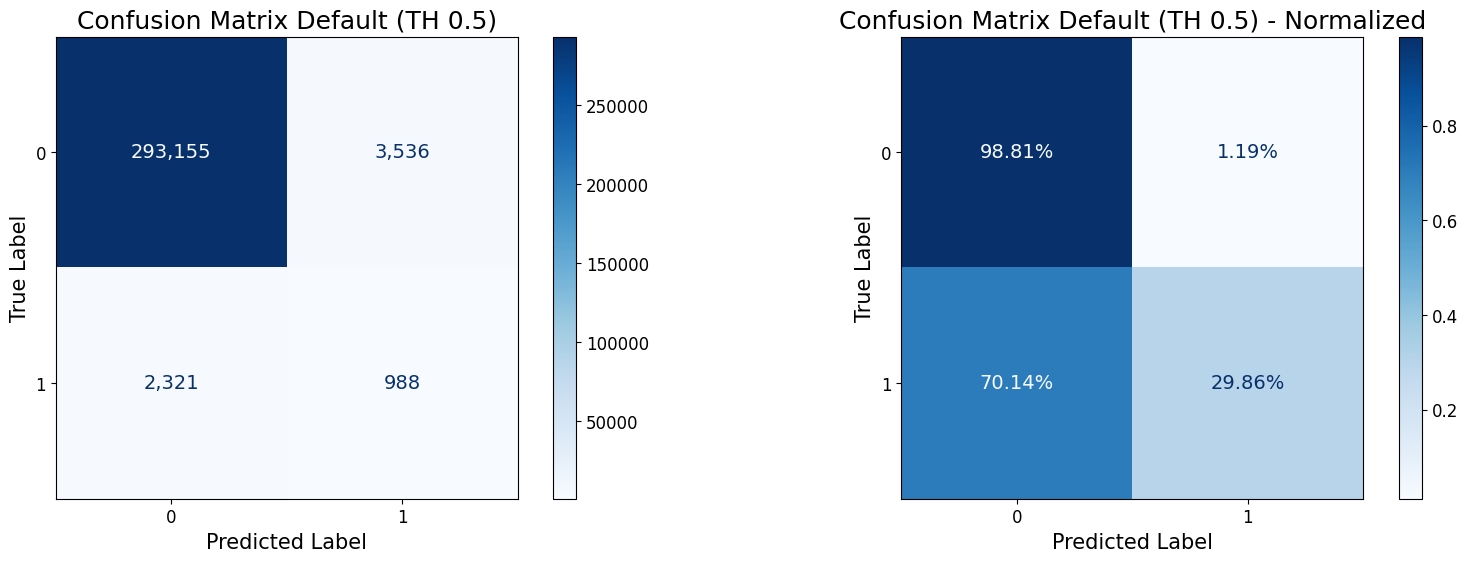

In [318]:
fr.plot_cmatrix(y_test, y_pred, title='Confusion Matrix Default (TH 0.5)')

### 2. Matriz de confusión con el Threshold ideal de la curva ROC (más TP promedio y mucho Recall, pero mucha menos Precision):

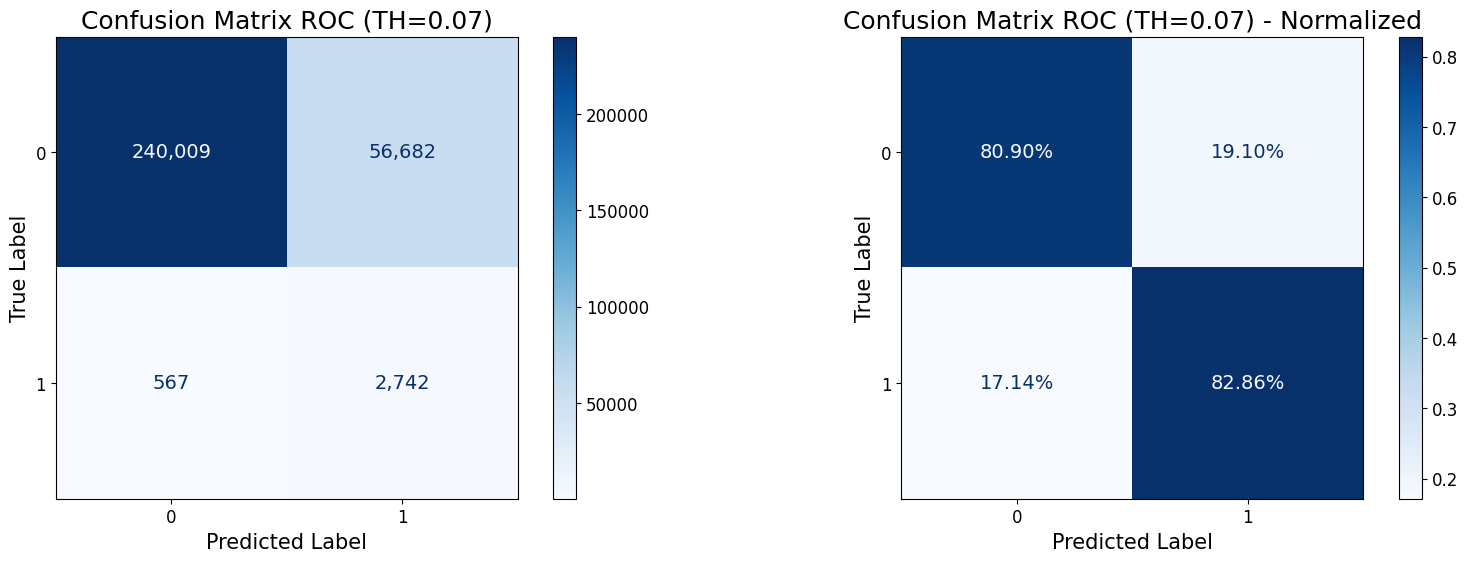

In [319]:
fr.plot_cmatrix(y_test, y_pred_th_roc, title='Confusion Matrix ROC (TH=0.07)')

### 3. Matriz de confusión que maximiza el F2: Equilibrio entre tener más Recall y no sacrificar tanta tanta Precision y Accuracy

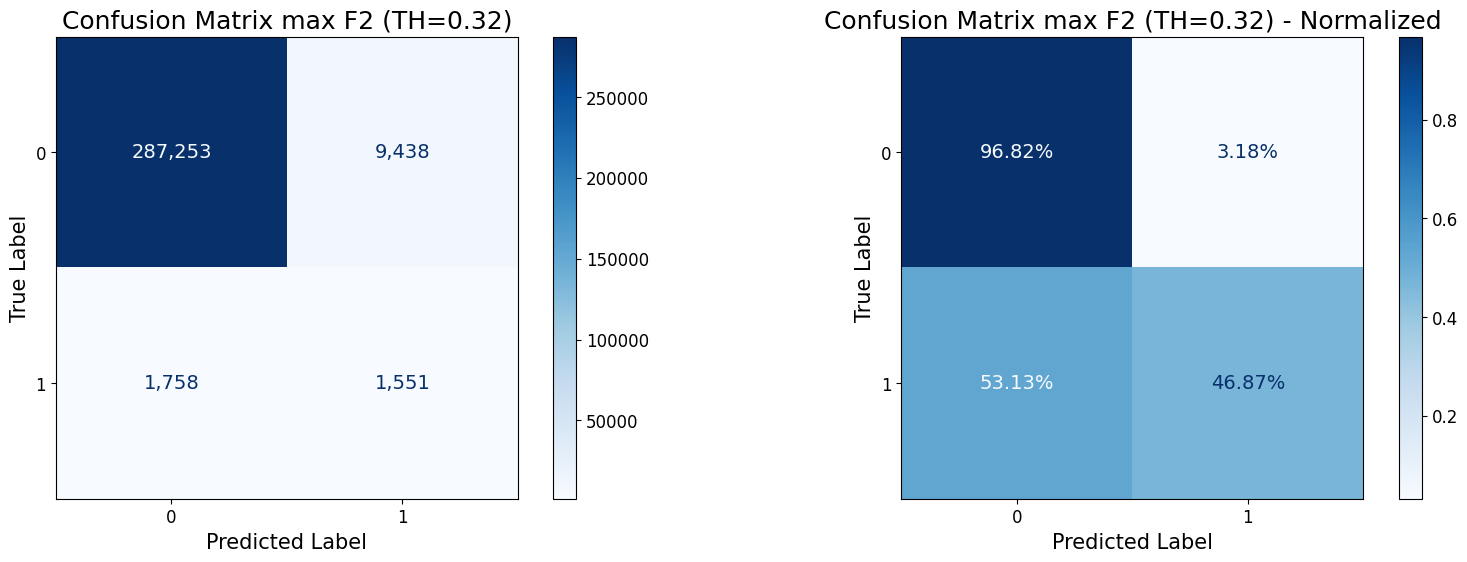

In [320]:
fr.plot_cmatrix(y_test, y_pred_th_f2, title='Confusion Matrix max F2 (TH=0.32)')

### 4. Ejemplo en donde negocio admite como máximo un 5% de Falsos Positivos... ¿Cuantos Fraudes alcanzamos a detectar?

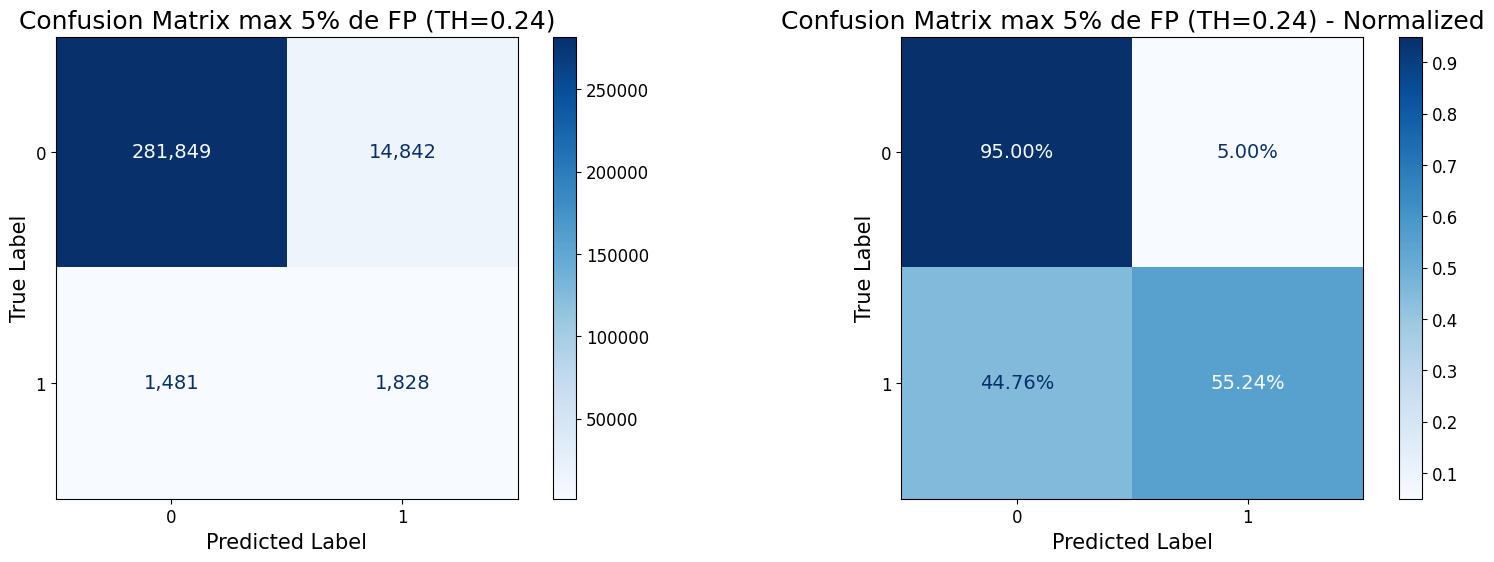

In [321]:
fr.plot_cmatrix(y_test, y_pred_th_5fp, title='Confusion Matrix max 5% de FP (TH=0.24)')

Con estas 4 matrices de confusión creo que he logrado mostrar de manera clara como dependiendo del objetivo que persigamos vamos a determinar un umbral u
otro en cuanto a las probabilidades otorgadas por el modelo. Como he comentado ya varias veces, no definiría una como mejor o peor, sino que nuestra elección dependerá de la cantidad de investigaciones que podamos realizar, del nivel de precisión que busquemos, entre otros factores.

Ahora si lo que podemos observar de una manera muy clara es como sacrificando Precision (y por ende incurriendo en más falsos positivos) hemos logrado aumentar bastante el número de fraudes detectados de manera correcta, disminuyendo en el proceso los fraudes no identificados. Por supuesto que sería posible priorizar el disminuír costos de investigación y ceder a detectar más fraudes, o por el contrario, estar dispuestos a tener más falsos positivos con el fin de aumentar aún más el Recall.

El modelo seguramente sea mejorable y quede mucho por aprender, pero es bueno saber que se estaría pasando de detectar 0 fraudes con un modelo base o muy baja cantidad con modelos simples, a lograr detectar un 50% de los mismos sin ceder tanto Accuracy en el proceso. Teniendo que soportar falsos negativos si, pero que a su vez estos representan menos del 4% de los casos por ejemplo cuando se maximiza el Recall. Si buscasemos más, podemos disminuír el threshold por supuesto, pero recordemos que desde el business case seteamos como principal métrica al F2, obviamente considerando al F1, recall y precision tambien, aunque en menor medida.

Un caso que decidí incluír porque me pareció algo que podría pasar es el hecho de buscar el mayor recall posible siempre y cuando no superemos el 5% de falsos positivos debido a que hasta ahí podría llegar la empresa en cuanto a costos de investigación. Esto sería lo mismo que decir, el máximo recall posible sin bajar del 95% de accuracy.

No es algo menor el hecho de recalcar que sería muy importante acompañar estas matrices de confusión con una matriz de costos. Al menos desde mi óptica, ya que considero que un Data Scientist debe ser alguien capacitado para usar la tecnología siempre en búsqueda de solucionar problemas de negocio, por ende el poder agregar datos económicos que permiten anexar directamente las limitaciones y objetivos financieros de la organización a las métricas del modelo sería algo escencial. Por ello es que decido, al menos a modo de ejemplo, incluír un análisis básico de este tipo.

### Guardo mi modelo en .joblib:

In [338]:
dump(lgbm, '../models/lgbm_model.joblib')

['../models/lgbm_model.joblib']

## Ejemplo de matriz de costos

Fueron varias las veces que he mencionado a la matriz de costos, por lo que daré un ejemplo de como se podría medir la direccionalidad de nuestro análisis desde el punto de vista económio de una empresa que busca maximizar sus beneficios (en este caso reduciendo costos).

* En el ejemplo no se premia a la detección de no fraudes (accuracy) debido a que es el estándar y no agrega más valor que lo que haría cualquier modelo simple
* En cambio si se considera como costo (2) un falso positivo, debido a que implicaría costos de investigación de potencial fraude.
* Aún así, es mucho más costoso aún (10) el no etiquetar a un individuo como potencial fraude cuando si lo es, por lo que el detrimento económico es mayor en este caso.
* Por último, el mayor beneficio se da cuando detectamos a un fraude que si lo es, disminuyendo el coste de la matriz en gran medida (-20), ya que es nuestro objetivo principal.

Por supuesto que los números son arbitrarios y ejemplificativos, seguramente podrían cambiar y tendrían mayor complejidad de cálculo en un caso real, pero sirve de ejemplo para mostrar como ayudaría en el análisis el poseer información de este estilo que complemente a las métricas que ya tenemos.

In [331]:
cm_cost = np.array([[0,2],[10,-20]]) # genero el array de dos dimensiones para poder operar con él
cm_cost

# genero un array y no una matriz por el tipo de operación que quiero realizar. No busco multiplicar matrices de la manera correcta desde el punto de vista del álgebra matricial,
# sino que busco realizar una multiplicación de cada uno de sus valores en el mismo orden en el que se encuentran.

array([[  0,   2],
       [ 10, -20]])

##### Matriz por default, sin estrategia de threshold (queda en 0.5):

In [323]:
confusion_matrix(y_test, y_pred) * cm_cost # multiplico cada valor por su costo asignado en la matriz de confusión por defecto

array([[     0,   7072],
       [ 23210, -19760]], dtype=int64)

In [332]:
(confusion_matrix(y_test, y_pred) * cm_cost).sum() # calculo el costo total de mi matriz de confusión por defecto

10522

##### Matriz max TP, threshold 0.07 --> Muchísimo recall pero baja precision

In [329]:
confusion_matrix(y_test, y_pred_th_roc) * cm_cost # hago lo mismo pero en este caso para la matriz de confusión en base al threshold óptimo para maximizar el F2

array([[     0, 113364],
       [  5670, -54840]], dtype=int64)

In [333]:
(confusion_matrix(y_test, y_pred_th_roc) * cm_cost).sum() # calculo el costo total de la matriz que maximiza el F2

64194

##### Matriz max F2, threshold 0.32 --> Matriz más equilibrada, probablemente la que más se asemeja a lo que busca premiar la matriz de costos

In [327]:
confusion_matrix(y_test, y_pred_th_f2) * cm_cost # hago lo mismo pero en este caso para la matriz de confusión en base al threshold óptimo para maximizar el F2

array([[     0,  18876],
       [ 17580, -31020]], dtype=int64)

In [335]:
(confusion_matrix(y_test, y_pred_th_f2) * cm_cost).sum() # calculo el costo total de la matriz que maximiza el F2

5436

##### Matriz límite 5% de FP --> Muy similar a la que maximiza el F2, con más recall y menos precision. Sería una buena alternativa también.

In [336]:
confusion_matrix(y_test, y_pred_th_5fp) * cm_cost # hago lo mismo pero en este caso para la matriz de confusión en base al threshold óptimo para maximizar el F2

array([[     0,  29684],
       [ 14810, -36560]], dtype=int64)

In [337]:
(confusion_matrix(y_test, y_pred_th_5fp) * cm_cost).sum() # calculo el costo total de la matriz que maximiza el F2

7934

Con este simple ejemplo podemos ver de que manera se premian o se castigan las estrategias de threshold que utilicemos en base a datos del negocio. Por más
que se capturen grandes cantidades de TP, con un threshold de 0.7 se incurrirían en enormes gastos de investigación. En cambio, con cualquiera de las dos matrices mostradas al último se logra mejorar el costo total y parecería adecuado para lo que representaría un negocio de este estilo.

***
Una vez finalizada la implementación y medición del modelo, solo quedará profundizar en su explicabilidad, ejercicio que realizaré en el próximo notebook.